# Simulating Montbrio Model

In [1]:
import os
import sys
import time
import timeit

import numpy as np
import scipy as sci
import seaborn as sns

In [2]:
import numba
from numba import jit, njit

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [4]:
%pylab inline
#%matplotlib notebook

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

Populating the interactive namespace from numpy and matplotlib


/home/meysam/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
cwd = os.getcwd()
cwd

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/SBI/MPR_NMM_SBI'

In [8]:
Res_dir='Res_PhasePlane'

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $



In [9]:
def Montbrio_model(v0, r0, delta, alpha, beta, I_input, dt, sigma):
    
    nsteps=len(I_input)
    r, v= np.zeros(nsteps), np.zeros(nsteps)
    
    v_init, r_init=v0, r0
    v[0],r[0]=v_init, r_init
    
    for i in range(1, nsteps):
        dr =(delta/np.pi) +2*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + beta*np.sqrt(delta)*r[i-1]+ alpha*delta +I_input[i-1]
        r[i]=(r[i-1] + dt * dr +np.sqrt(dt) *sigma * np.random.randn())
        v[i]=(v[i-1] + dt * dv +np.sqrt(dt) *sigma * np.random.randn())    
    
    return v,r

In [10]:
Montbrio_model_numba = numba.jit(Montbrio_model)

In [11]:
delta=0.7
eta=-4.6
J=14.5

In [12]:
alpha=eta/delta
beta=J/np.sqrt(delta)
alpha, beta

(-6.571428571428571, 17.330814835348708)

In [13]:
dt = 0.001
t_init = 0.0
t_final = 100.0
nsteps = int((t_final - t_init)/dt)
Ts = np.arange(t_init,t_final,dt)

In [14]:
I0=3.
t0In=30
tn_In=60

I_input=[]
I_input = [0 for i in range(int((t0In - t_init)/dt))]+ [I0 for i in range(int((tn_In - t0In)/dt))]+ [0 for i in range(int((t_final - tn_In)/dt))]
I_input =np.asarray(I_input)

In [15]:
sigma=0.1

In [16]:
v0 = -3.
r0 = .5

In [17]:
start_time = time.time()

v,r = Montbrio_model(v0, r0, delta, alpha, beta, I_input, dt, sigma)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8395345211029053 seconds ---


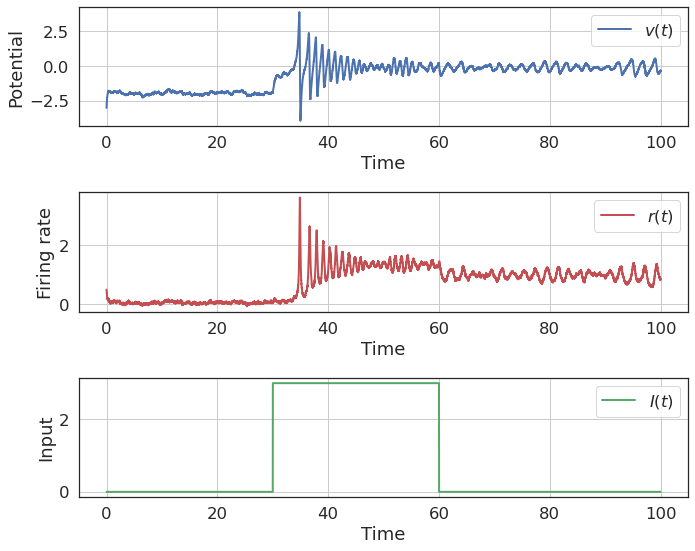

In [18]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(Ts, v, 'b', linewidth=2, label='$v(t)$')
plt.xlabel('Time'); plt.ylabel('Potential'); 
plt.legend(loc='upper right')
plt.grid()

plt.subplot(312)
plt.plot(Ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time'); plt.ylabel('Firing rate'); 
plt.legend(loc='upper right')
plt.grid()

plt.subplot(313)
plt.plot(Ts, I_input, 'g', linewidth=2, label='$I(t)$')
plt.xlabel('Time'); plt.ylabel('Input'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_ode_Istep_ratios.png"), dpi=300)
plt.show()

### LAS functions

In [19]:
def plot_nullcline(ax, delta, eta, J, I0, linewidth=3, style='--',  vmin=-20,vmax=20):
    v = np.linspace(vmin,vmax,100000)
    nullcline_v=-delta/(2*np.pi*v)
    nullcline_r=v**2  -(np.pi*(-delta/(2*np.pi*v)))**2 + J*(-delta/(2*np.pi*v))+ eta +I0
    ax.plot(v, nullcline_v , style, color='khaki', linewidth=linewidth, label='v-nullcline')
    ax.plot(v, nullcline_r , style, color='y', linewidth=linewidth, label='r-nullcline')
    #ax.legend(fontsize=14, frameon=False)

In [20]:
def MontbrioFlow(x, t, delta, alpha, beta, I0):
    Fr=(delta/np.pi) +(2*x[0]*x[1])
    Fv=(x[1]**2)  -(np.pi*x[0])**2 + beta*np.sqrt(delta)*x[0]+ alpha*delta +I0
    F=np.array([Fr, Fv])
    return F

In [21]:
def plot_vector_field(ax, param, xrange, yrange, steps=1000):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    dx,dy = MontbrioFlow([X,Y],0,**param)   
    ax.streamplot(X,Y,dx, dy, density=2.0, color='lightgray')
    ax.contour(X,Y,dx, [0], linestyles='--', linewidths=3, colors="khaki", alpha=0.9, zorder=4)
    ax.contour(X,Y,dy, [0], linestyles='--', linewidths=3, colors="y", alpha=0.9, zorder=4)
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))
    ax.plot([], [], 'khaki', linestyle='--', linewidth=2, label='v-nullcline')
    ax.plot([], [], 'y', linestyle='--', linewidth=2, label='r-nullcline')
    ax.legend(loc='lower right', frameon=False, fontsize=14)

In [22]:
def find_roots(delta, alpha, beta, I0):
    coef = [1, 0, ((alpha*delta)+I0), -(beta*np.sqrt(delta)*delta)/(2*np.pi), -(delta/2)**2]
    # We are only interested in real roots.
    # np.isreal(x) returns True only if x is real. 
    # The following line filter the list returned by np.roots
    # and only keep the real values. 
    roots = [np.real(v) for v in np.roots(coef) if np.isreal(v)]
    # We store the position of the equilibrium (r*,v*). 
    return [[-delta/(2*np.pi*v), v] for v in roots]

### Linear Stability Analysis (LSA)

In [23]:
scenarios = [
     {"delta":0.7, "alpha":-6.57, "beta":17.33, "I0":0.},
     {"delta":0.7, "alpha":-0.1, "beta":20, "I0":0.},
     {"delta":0.7, "alpha":-10, "beta":10, "I0":0.}
]

In [24]:
stability_lables=['bi-stable', 'stabel-focus', 'stable-node']

In [25]:
eqnproot = {}
for i, param in enumerate(scenarios):
    eqnproot[i] = find_roots(**param)

In [26]:
eqnproot

{0: [[-0.04829165124928494, 2.306992146307616],
  [0.05712976526170048, -1.9500948350476497],
  [0.4521801396563478, -0.24638070183488375],
  [1.008069834424734, -0.1105166094250833]],
 1: [[-0.0877061827627834, 1.270246368669929],
  [1.691494507728299, -0.06586392072531756]],
 2: [[-0.04106509300777753, 2.712972308213852],
  [0.0431791789191628, -2.5801430910230665]]}

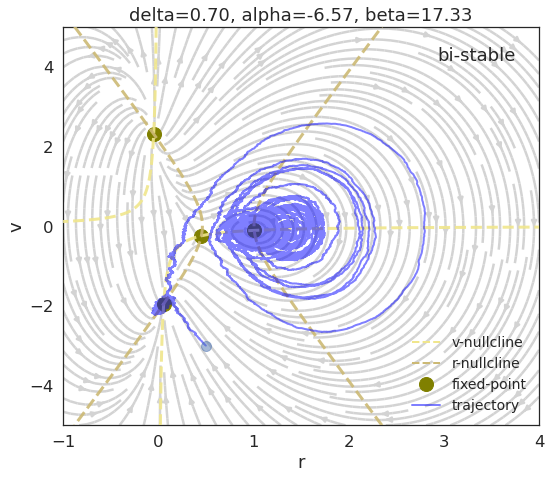

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
j=0
param=scenarios[j]
xrange = (-1, 4) 
yrange =(-5, 5)
v,r = Montbrio_model(v0, r0, param['delta'], param['alpha'], param['beta'], I_input, dt, sigma)
plot_vector_field(ax, param, xrange, yrange)
#plot_nullcline(ax, **param)
for i in range (len(eqnproot[j])):
    if i == len(eqnproot[j]) - 1:
        plt.plot(eqnproot[j][i][0], eqnproot[j][i][1], marker="o", markersize=14, lw=0, color='olive', zorder=3, label='fixed-point')
    else:
        plt.plot(eqnproot[j][i][0], eqnproot[j][i][1], marker="o", markersize=14, lw=0, color='olive', zorder=3)

plt.plot(r,v,  marker="o", markersize=0, lw=2, color='blue',  alpha=0.5, label='trajectory', zorder=4)
plt.plot(r[0],v[0],  marker="o", markersize=10, lw=0, color='b', alpha=0.5, zorder=5)

ax.set(xlabel='r', ylabel='v',  title="delta={:.2f}".format(param["delta"]) +", alpha={:.2f}".format(param["alpha"]) +", beta={:.2f}".format(param["beta"]))
ax.legend(loc='lower right', frameon=False, fontsize=14)
text = 'bi-stable'
ax.text(0.95, 0.95, text, transform=ax.transAxes,
        horizontalalignment='right', verticalalignment='top', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_phaseplane_bistable_ratios.png"), dpi=300)
plt.show()

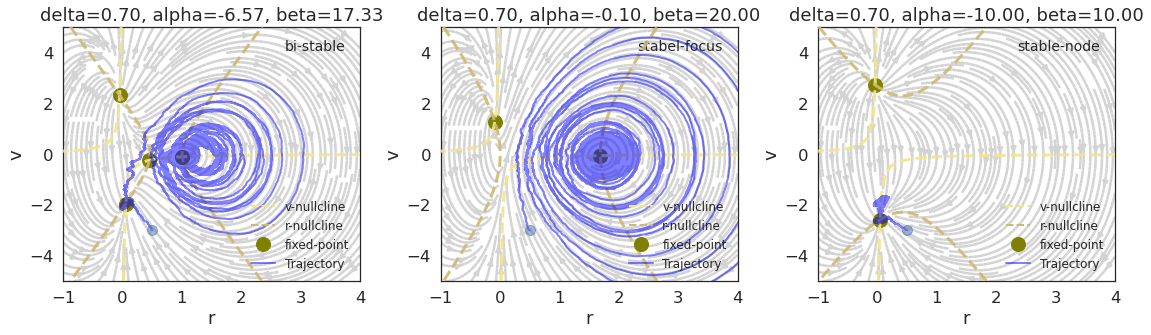

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for j in range(len(scenarios)):
    param=scenarios[j]
    xrange = (-1, 4) 
    yrange =(-5, 5)
    v,r = Montbrio_model(v0, r0, param['delta'], param['alpha'], param['beta'], I_input, dt, sigma)
    plot_vector_field(ax[j], param, xrange, yrange)
    #plot_nullcline(ax, **param)
 
    for i in range (len(eqnproot[j])):
        if i == len(eqnproot[j]) - 1:
            ax[j].plot(eqnproot[j][i][0], eqnproot[j][i][1], marker="o", markersize=14, lw=0, color='olive', zorder=3, label='fixed-point')
        else:
            ax[j].plot(eqnproot[j][i][0], eqnproot[j][i][1], marker="o", markersize=14, lw=0, color='olive', zorder=3)
   
    ax[j].plot(r,v,  marker="o", markersize=0, lw=2, color='blue', alpha=0.5, label='Trajectory', zorder=4)
    ax[j].plot(r[0],v[0],  marker="o", markersize=10, lw=0, color='b', alpha=0.5, zorder=5)
    
    ax[j].legend(loc='lower right', frameon=False, fontsize=12)
    ax[j].set(xlabel='r', ylabel='v',  title="delta={:.2f}".format(param["delta"]) +", alpha={:.2f}".format(param["alpha"]) +", beta={:.2f}".format(param["beta"]))
    ax[j].text(0.95, 0.95, stability_lables[j], transform=ax[j].transAxes,
        horizontalalignment='right', verticalalignment='top', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_phaseplane_senarios_ratios.png"), dpi=300)
plt.show()

In [29]:
EQUILIBRIUM_COLOR = {'Stable node':'C6',
                    'Unstable node':'C1', 
                    'Saddle':'C2',
                    'Stable focus':'C3',
                    'Unstable focus':'C4',
                    'Center':'C0'}

In [30]:
def Jacobian_Montbrio(r, v, delta, alpha, beta, I0):
    """ Jacobian matrix of the Monbrio's excitable system
    Args
    ====
    r, v, delta, alpha, beta
    Return: np.array 2x2"""
    return np.array([[2*v, 2*r],
                       [(-2*(np.pi**2)*r)+(beta*np.sqrt(delta)), 2*v]])

In [31]:
def stability(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Use the eigenvalues. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point.
    """
    
    eigv = np.linalg.eigvals(jacobian)
    
    
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

def stability_alt(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Use the trace and determinant. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point.
    """
    
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace, 0):
        nature = "Center (Hopf)"
    elif np.isclose(determinant, 0):
        nature = "Transcritical (Saddle-Node)"
    elif determinant < 0:
        nature = "Saddle"
    else:
        nature = "Stable" if trace < 0 else "Unstable"
        nature += " focus" if (trace**2 - 4 * determinant) < 0 else " node"
    return nature

In [32]:
eqstability = {}
for i, param in enumerate(scenarios):
    print(i, eqnproot)
    eqstability[i] = []
    for e in eqnproot[i]:
        _ = Jacobian_Montbrio(e[0],e[1], **param)
        eqstability[i].append(stability(_))    
eqstability

0 {0: [[-0.04829165124928494, 2.306992146307616], [0.05712976526170048, -1.9500948350476497], [0.4521801396563478, -0.24638070183488375], [1.008069834424734, -0.1105166094250833]], 1: [[-0.0877061827627834, 1.270246368669929], [1.691494507728299, -0.06586392072531756]], 2: [[-0.04106509300777753, 2.712972308213852], [0.0431791789191628, -2.5801430910230665]]}
1 {0: [[-0.04829165124928494, 2.306992146307616], [0.05712976526170048, -1.9500948350476497], [0.4521801396563478, -0.24638070183488375], [1.008069834424734, -0.1105166094250833]], 1: [[-0.0877061827627834, 1.270246368669929], [1.691494507728299, -0.06586392072531756]], 2: [[-0.04106509300777753, 2.712972308213852], [0.0431791789191628, -2.5801430910230665]]}
2 {0: [[-0.04829165124928494, 2.306992146307616], [0.05712976526170048, -1.9500948350476497], [0.4521801396563478, -0.24638070183488375], [1.008069834424734, -0.1105166094250833]], 1: [[-0.0877061827627834, 1.270246368669929], [1.691494507728299, -0.06586392072531756]], 2: [[

{0: ['Unstable focus', 'Stable node', 'Saddle', 'Stable focus'],
 1: ['Unstable focus', 'Stable focus'],
 2: ['Unstable focus', 'Stable node']}

In [33]:
import matplotlib.patches as mpatches #used to write custom legends

def plot_phase_diagram(v0, r0, param, I_input, dt, sigma, ax=None, title=None):
    """Plot a complete Montbrio phase Diagram in ax.
    Including isoclines, flow vector field, equilibria and their stability"""
    if ax is None:
        ax = plt.gca()
    #if title is None:
        #title = "Phase space, {}".format(param) 
    
    ax.set(xlabel='r', ylabel='v', title=title)
        
    xrange = (-1, 4) 
    yrange =(-5, 5)
    v,r = Montbrio_model(v0, r0, param['delta'], param['alpha'], param['beta'], I_input, dt, sigma)
    plot_vector_field(ax, param, xrange, yrange)
    #plot_nullcline(ax, **param)
 
    
    # Plot the equilibria 
    eqnproot = find_roots(**param)
    eqstability = [stability(Jacobian_Montbrio(e[0],e[1], **param)) for e in eqnproot] 
    for e,n in zip(eqnproot,eqstability):
        ax.scatter(*e, color=EQUILIBRIUM_COLOR[n], s=120, zorder=8)
        
        ax.plot(r,v,  marker="o", markersize=0, lw=2, color='blue', alpha=0.5, label='Trajectory', zorder=4)
        ax.plot(r[0],v[0],  marker="o", markersize=10, lw=0, color='blue', alpha=0.5, zorder=5)
    

    # Legend
    labels = frozenset(eqstability)
    ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
           loc='lower right', fontsize=12)

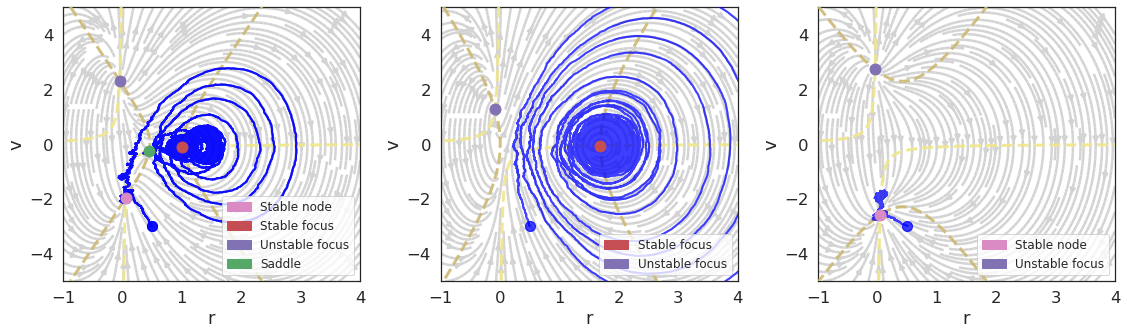

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, param in enumerate(scenarios):
    plot_phase_diagram(v0, r0, param, I_input, dt, sigma, ax[i])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_phaseplane_stablity_senarios_ratios.png"), dpi=300)
plt.show()

### Bifircation Diagram

In [35]:
alpha_span = np.linspace(-15,0.,500)
beta_span = np.linspace(.1,30,500)

In [36]:
stable_focus=[]
stable_node=[]
bi_stable = []
wierd=[]

for x,i in enumerate(alpha_span):
    for y,j in enumerate(beta_span):
        param =  {"delta":0.7, "alpha":i, "beta":j, "I0":0.}
        ro = find_roots(**param)
        stab = [stability(Jacobian_Montbrio(r,v, **param)) for r,v in ro]
        # Check how many of the equilibria is stable. 
        count_stab = np.sum(1 for item in stab if 'Stable' in item)
        if (count_stab) >= 2:
            bi_stable.append((i,j))
        else:     
            if stab.count('Stable focus') == 1:
                stable_focus.append((i,j))
            elif stab.count('Stable node') == 1:
                stable_node.append((i,j)) 
            else:     
                wierd.append((i,j))

In [37]:
wierd

[]

In [38]:
delta_true=0.7
eta_true=-4.6
J_true=14.5

alpha_true=eta_true/delta_true
beta_true=J_true/np.sqrt(delta_true)
alpha_true, beta_true

(-6.571428571428571, 17.330814835348708)

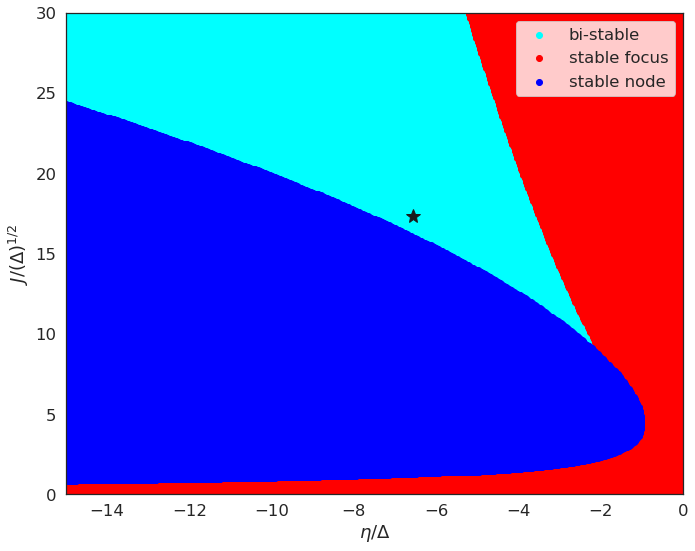

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(*zip(*bi_stable), color='cyan', marker='o', label='bi-stable')
plt.scatter(*zip(*stable_focus), color='red', marker='o' ,label='stable focus')
plt.scatter(*zip(*stable_node), color='blue', marker='o', label='stable node')
plt.plot(alpha_true, beta_true, color='k', marker='*', markersize=14)
plt.xlabel('$\eta/\Delta$'); plt.ylabel('$J/(\Delta)^{1/2}$'); 
plt.legend(loc='upper right')
plt.xlim([-15, 0])
plt.ylim([0, 30])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_BifurcationDiagram_ratios.png"), dpi=300)
plt.show()

In [40]:
delta_span=np.linspace(.1,2.,50)
alpha_span = np.linspace(-15,0.,500)
beta_span = np.linspace(.1,30,500)

In [41]:
stable_focus=[]
stable_node=[]
bi_stable = []
wierd=[]

for z, k in enumerate(delta_span):
    for x,i in enumerate(alpha_span):
        for y,j in enumerate(beta_span):
            param =  {"delta":k, "alpha":i, "beta":j, "I0":0.}
            ro = find_roots(**param)
            stab = [stability(Jacobian_Montbrio(r,v, **param)) for r,v in ro]
            # Check how many of the equilibria is stable. 
            count_stab = np.sum(1 for item in stab if 'Stable' in item)
            if (count_stab) >= 2:
                bi_stable.append((i/k,j/np.sqrt(k)))
            else:     
                if stab.count('Stable focus') == 1:
                    stable_focus.append((i/k,j/np.sqrt(k)))
                elif stab.count('Stable node') == 1:
                    stable_node.append((i/k,j/np.sqrt(k))) 
                else:     
                    wierd.append((i/k,j/np.sqrt(k)))


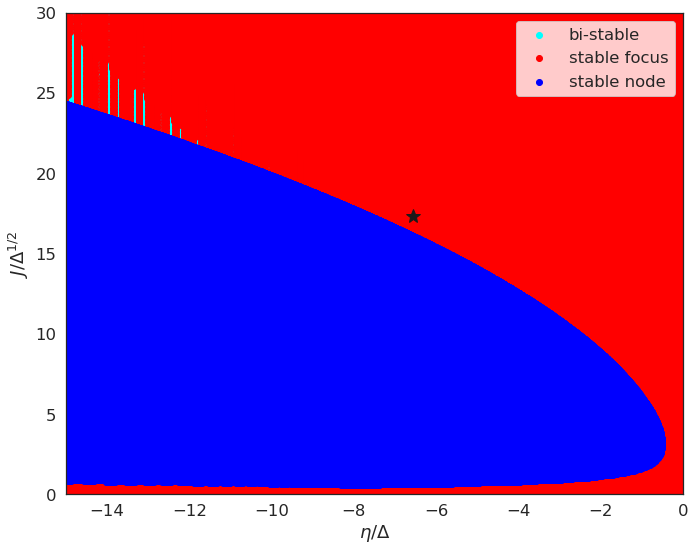

In [42]:
plt.figure(figsize=(10, 8))
plt.scatter(*zip(*bi_stable), color='cyan', marker='o', label='bi-stable')
plt.scatter(*zip(*stable_focus), color='red', marker='o' ,label='stable focus')
plt.scatter(*zip(*stable_node), color='blue', marker='o', label='stable node')
plot(eta_true/delta_true, J_true/np.sqrt(delta_true), color='k', marker='*', markersize=14)
plt.xlabel('$\eta/\Delta$'); plt.ylabel('$J/\Delta^{1/2}$'); 
plt.legend(loc='upper right')
plt.xlim([-15, 0])
plt.ylim([0, 30])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_BifurcationDiagramRatios_ratios.png"), dpi=300)
plt.show()